# UMAP Performance Analysis: JavaScript vs WebAssembly Features

## Research Questions

**RQ1**: What is the performance impact of individual WASM features (Distance, Tree, Matrix, NN Descent, Optimizer) compared to pure JavaScript?

**RQ2**: How does enabling all WASM features together compare to individual features and pure JavaScript?

## Methodology

- **Baseline**: Pure JavaScript UMAP implementation (no WASM)
- **Individual Features**: Each WASM feature enabled separately (Dist, Tree, Matrix, NN, Opt)
- **All Features**: All WASM features enabled simultaneously
- **Metrics**: Runtime (ms), Memory (MB), Quality (trustworthiness), FPS, Responsiveness (ms)
- **Statistical Analysis**: Mann-Whitney U tests, bootstrap confidence intervals, effect sizes
- **Analysis Focus**: Single machine analysis to isolate implementation performance differences

## 1. Setup and Data Loading

In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistical analysis
from scipy import stats
from scipy.stats import mannwhitneyu, bootstrap

# Set styling for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 3)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All dependencies loaded successfully")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

✓ All dependencies loaded successfully
  pandas: 2.3.3
  numpy: 2.4.1


In [2]:
# Load data
df = pd.read_csv('../outputs/preprocessed.csv')

print(f"Total rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"\nSample of dataset_name and dataset_size:")
print(df[['dataset_name', 'dataset_size']].drop_duplicates().sort_values('dataset_name'))
print(f"\nDataset size statistics:")
print(df['dataset_size'].describe())
print(f"\nFirst few rows:")
df.head()

Total rows: 420
Columns: 35

Sample of dataset_name and dataset_size:
                             dataset_name  dataset_size
281         3D Dense Clusters (1K points)          1000
0           Iris Dataset (150 points, 4D)           150
280          MNIST-like (1K points, 784D)          1000
141         Medium Clustered (600 points)           600
1                Small Random (80 points)            80
140  Swiss Roll (600 points, 3D manifold)           600

Dataset size statistics:
count     420.000
mean      571.667
std       362.851
min        80.000
25%       150.000
50%       600.000
75%      1000.000
max      1000.000
Name: dataset_size, dtype: float64

First few rows:


,generated_at,runs_declared,result_run,result_wasm_features,result_duration_ms,stats_start_time,stats_duration_ms,wasm_features_file,wasm_preload,machine_platform,machine_release,machine_arch,cpu_model,cpu_cores,total_mem_bytes,load_avg_1,load_avg_5,load_avg_15,hostname,git_commit,git_branch,git_status_dirty,ui_run_id,ui_timestamp,scope,dataset_name,dataset_size,dimensions,ui_wasm_features,wasm_mode,runtime_ms,memory_delta_mb,trustworthiness,fps_avg,responsiveness_ms
0,2026-01-31T12:39:27.635Z,10,1,none,43526,2026-01-31T12:39:45.906Z,25293.620,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:40:03.865Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2326.9,-0.055,0.987,60.000,8.600
1,2026-01-31T12:39:27.635Z,10,1,none,43526,2026-01-31T12:39:45.906Z,25293.620,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,2,2026-01-31T12:40:11.571Z,small,Small Random (80 points),80,10,none,js,3404.4,-4.720,0.877,48.205,24.000
2,2026-01-31T12:39:27.635Z,10,2,none,45124,2026-01-31T12:40:27.525Z,28781.219,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:40:50.544Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2297.1,2.982,0.992,60.000,9.073
3,2026-01-31T12:39:27.635Z,10,2,none,45124,2026-01-31T12:40:27.525Z,28781.219,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,2,2026-01-31T12:40:56.801Z,small,Small Random (80 points),80,10,none,js,3291.8,14.747,0.831,48.000,22.900
4,2026-01-31T12:39:27.635Z,10,3,none,46734,2026-01-31T12:41:11.846Z,31195.437,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:41:36.835Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2334.0,1.220,0.989,59.994,9.882


## 2. Data Cleaning and Preparation

In [3]:
# Standardize column names and prepare data
df_clean = df.copy()

# Create standardized feature column
df_clean['feature'] = df_clean['result_wasm_features'].fillna('none').str.lower().str.strip()

# Standardize feature names
feature_map = {
    'none': 'Baseline (JS)',
    'dist': 'Distance',
    'tree': 'Tree',
    'matrix': 'Matrix',
    'nn': 'NN Descent',
    'opt': 'Optimizer',
    'all': 'All Features'
}
df_clean['feature_name'] = df_clean['feature'].map(feature_map)

# Identify machine types
df_clean['machine_type'] = df_clean['machine_platform'].map({
    'darwin': 'MacBook',
    'linux': 'Linux'
})

# Convert numeric columns
numeric_cols = ['runtime_ms', 'memory_delta_mb', 'trustworthiness', 'fps_avg', 'responsiveness_ms']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Remove missing values in key columns
df_clean = df_clean.dropna(subset=['runtime_ms', 'feature_name', 'machine_type'])

print(f"\nAfter cleaning: {len(df_clean):,} rows")
print(f"\nFeature distribution:")
print(df_clean['feature_name'].value_counts().sort_index())
print(f"\nMachine distribution:")
print(df_clean['machine_type'].value_counts())
print(f"\nDataset distribution:")
print(df_clean['dataset_name'].value_counts())


After cleaning: 420 rows

Feature distribution:
feature_name
All Features     60
Baseline (JS)    60
Distance         60
Matrix           60
NN Descent       60
Optimizer        60
Tree             60
Name: count, dtype: int64

Machine distribution:
machine_type
Linux    420
Name: count, dtype: int64

Dataset distribution:
dataset_name
Iris Dataset (150 points, 4D)           70
Small Random (80 points)                70
Swiss Roll (600 points, 3D manifold)    70
Medium Clustered (600 points)           70
MNIST-like (1K points, 784D)            70
3D Dense Clusters (1K points)           70
Name: count, dtype: int64


In [4]:
# Select machine for analysis
# Automatically select the machine with the most data, or manually specify
available_machines = df_clean['machine_type'].value_counts()
print("Available machines:")
print(available_machines)

# Select the machine with most data (or change this to 'Linux' or 'MacBook' explicitly)
SELECTED_MACHINE = available_machines.idxmax()
print(f"\n✓ Analyzing data from: {SELECTED_MACHINE}")
print(f"  Total measurements: {available_machines[SELECTED_MACHINE]:,}")

# Filter data to selected machine only
df_analysis = df_clean[df_clean['machine_type'] == SELECTED_MACHINE].copy()

print(f"\nFiltered dataset: {len(df_analysis):,} rows")
print(f"Features: {sorted(df_analysis['feature_name'].unique())}")
print(f"Datasets: {sorted(df_analysis['dataset_name'].unique())}")

Available machines:
machine_type
Linux    420
Name: count, dtype: int64

✓ Analyzing data from: Linux
  Total measurements: 420

Filtered dataset: 420 rows
Features: ['All Features', 'Baseline (JS)', 'Distance', 'Matrix', 'NN Descent', 'Optimizer', 'Tree']
Datasets: ['3D Dense Clusters (1K points)', 'Iris Dataset (150 points, 4D)', 'MNIST-like (1K points, 784D)', 'Medium Clustered (600 points)', 'Small Random (80 points)', 'Swiss Roll (600 points, 3D manifold)']


In [5]:
# Check for outliers and data quality
print("Data Quality Checks:")
print(f"Negative runtime values: {(df_analysis['runtime_ms'] < 0).sum()}")
print(f"Trustworthiness out of range [0,1]: {(~df_analysis['trustworthiness'].between(0, 1)).sum()}")
print(f"Negative FPS: {(df_analysis['fps_avg'] < 0).sum()}")
print(f"\nRuntime statistics by feature:")
df_analysis.groupby('feature_name')['runtime_ms'].describe()

Data Quality Checks:
Negative runtime values: 0
Trustworthiness out of range [0,1]: 0
Negative FPS: 0

Runtime statistics by feature:


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
All Features,60.0,2156.648,1244.351,609.4,758.525,2272.45,3411.550,4041.4
Baseline (JS),60.0,3574.622,854.386,2297.1,2939.200,3559.85,4518.850,4832.7
Distance,60.0,3526.283,865.774,2291.4,2922.125,3360.75,4515.950,4894.3
Matrix,60.0,3586.413,1029.929,2283.7,2897.625,3492.45,4509.350,6979.8
NN Descent,60.0,3555.917,884.902,2289.9,2918.975,3498.30,4573.775,4907.4
Optimizer,60.0,2143.775,1257.783,590.2,738.050,2088.40,3441.000,3967.2
Tree,60.0,3517.928,888.433,2288.5,2902.250,3340.90,4529.600,4796.4


## 3. Performance Distribution Analysis

Analyze the performance distribution across different features for the selected machine.

In [6]:
# Summary statistics by feature
feature_summary = df_analysis.groupby('feature_name').agg({
    'runtime_ms': ['count', 'mean', 'std', 'median', 'min', 'max'],
    'memory_delta_mb': ['mean', 'median'],
    'trustworthiness': ['mean', 'median'],
    'fps_avg': ['mean', 'median'],
    'responsiveness_ms': ['mean', 'median']
}).round(2)

print(f"Performance Summary for {SELECTED_MACHINE}:")
feature_summary

Performance Summary for Linux:


runtime_ms                                            memory_delta_mb        trustworthiness         \
                   count     mean      std   median     min     max            mean median            mean median   
feature_name                                                                                                        
All Features          60  2156.65  1244.35  2272.45   609.4  4041.4           10.73  12.18            0.89   0.97   
Baseline (JS)         60  3574.62   854.39  3559.85  2297.1  4832.7           11.61  13.57            0.90   0.97   
Distance              60  3526.28   865.77  3360.75  2291.4  4894.3           12.49  14.02            0.90   0.97   
Matrix                60  3586.41  1029.93  3492.45  2283.7  6979.8           13.06  10.82            0.90   0.97   
NN Descent            60  3555.92   884.90  3498.30  2289.9  4907.4           17.04  14.17            0.90   0.97   
Optimizer             60  2143.77  1257.78  2088.40   590.2  3967.2            5.30   2.02            0.89   0.97   
Tree                  60  3517.93   888.43  3340.90  2288.5  4796.4           17.19  14.82            0.90   0.97   

              fps_avg        responsiveness_ms         
                 mean median              mean median  
feature_name                                           
All Features    28.52  37.57             33.94  20.70  
Baseline (JS)   54.91  56.44             36.89  22.49  
Distance        55.19  56.99             36.70  21.53  
Matrix          54.92  56.92             34.29  20.79  
NN Descent      54.99  57.02             36.13  21.82  
Optimizer       27.91  37.84             35.93  22.05  
Tree            55.17  56.93             35.78  22.04

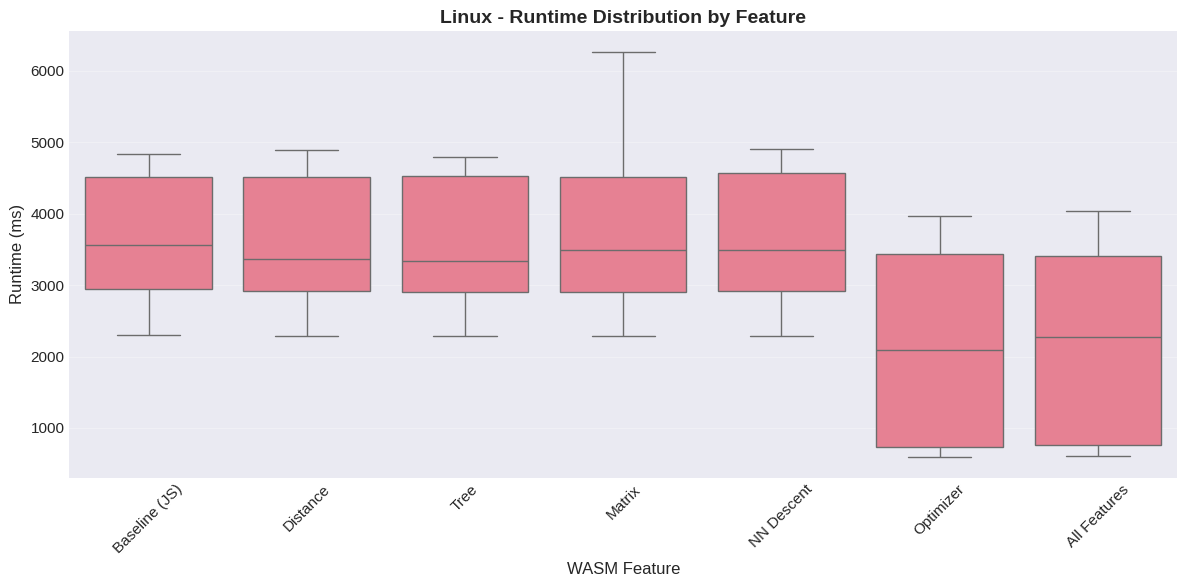

In [7]:
# Visualize runtime distribution by feature
fig, ax = plt.subplots(figsize=(12, 6))

# Order features logically
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

sns.boxplot(data=df_analysis, x='feature_name', y='runtime_ms', 
            order=feature_order, ax=ax, showfliers=False)
ax.set_title(f'{SELECTED_MACHINE} - Runtime Distribution by Feature', fontsize=14, fontweight='bold')
ax.set_xlabel('WASM Feature', fontsize=12)
ax.set_ylabel('Runtime (ms)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_distribution.png', bbox_inches='tight')
plt.show()

## 4. Baseline Comparison: Pure JS vs Individual Features

Analyze each WASM feature individually against the baseline JavaScript implementation.

In [9]:
def calculate_speedup(df, baseline_feature='Baseline (JS)', machine=None):
    """
    Calculate speedup relative to baseline for each machine/dataset combination.
    """
    results = []
    
    # Filter by machine if specified
    data = df[df['machine_type'] == machine] if machine else df
    
    # Group by dataset and machine
    for (dataset, mach), group in data.groupby(['dataset_name', 'machine_type']):
        baseline = group[group['feature_name'] == baseline_feature]['runtime_ms']
        
        if len(baseline) == 0:
            continue
            
        baseline_median = baseline.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline_feature:
                continue
                
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset': dataset,
                'machine': mach,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

# Calculate speedups
speedup_df = calculate_speedup(df_analysis)

print(f"Speedup Summary for {SELECTED_MACHINE}:")
speedup_summary = speedup_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std', 'min', 'max'],
    'improvement_pct': ['mean', 'median']
}).round(3)
speedup_summary

Speedup Summary for Linux:


speedup                             improvement_pct        
                mean median    std    min    max            mean  median
feature                                                                 
All Features   2.286  1.640  1.327  1.194  4.331         128.608  63.955
Distance       1.015  1.003  0.047  0.971  1.107           1.457   0.277
Matrix         1.024  1.005  0.049  0.996  1.123           2.410   0.504
NN Descent     1.013  0.992  0.050  0.988  1.115           1.281  -0.754
Optimizer      2.348  1.634  1.424  1.188  4.468         134.832  63.378
Tree           1.020  1.003  0.045  0.991  1.111           1.979   0.349

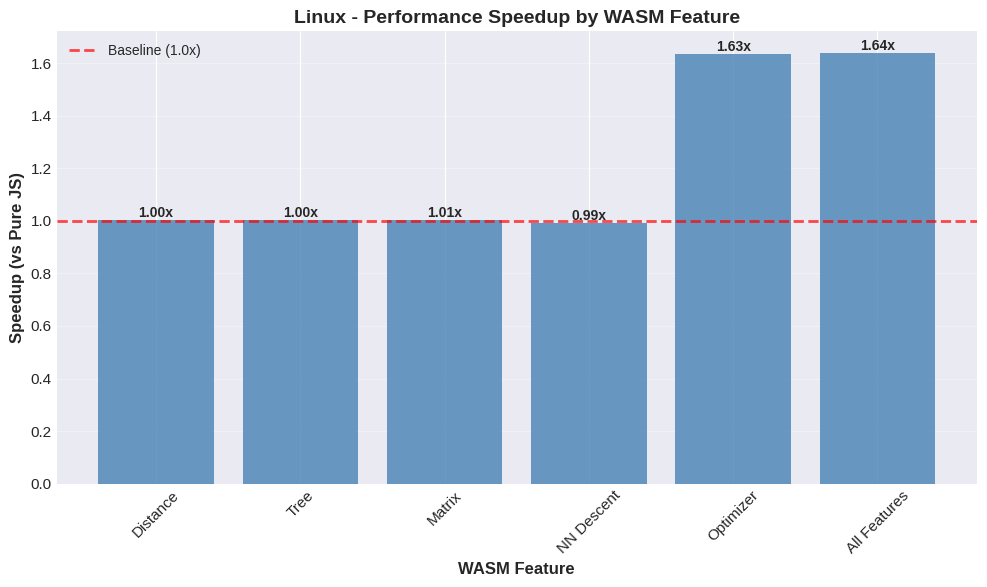

In [10]:
# Detailed speedup by feature
feature_order = ['Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in speedup_df['feature'].unique()]

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate median speedup for each feature
feature_speedups = speedup_df.groupby('feature')['speedup'].median()
values = [feature_speedups.get(f, 0) for f in feature_order]

bars = ax.bar(feature_order, values, alpha=0.8, color='steelblue')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}x',
               ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup (vs Pure JS)', fontsize=12, fontweight='bold')
ax.set_title(f'{SELECTED_MACHINE} - Performance Speedup by WASM Feature', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_comparison.png', bbox_inches='tight')
plt.show()

## 4.5. Dataset Size Analysis

Analyze how performance scales with dataset size and whether WASM features show different benefits for small vs large datasets.

In [11]:
# Extract dataset size information from the existing 'dataset_size' column
# This column is already in the CSV from the benchmark runs
df_analysis['dataset_size'] = pd.to_numeric(df_analysis['dataset_size'], errors='coerce')

# Benchmark dataset sizes:
# Small scope: Iris (150), Small Random (80)
# Mid scope: Swiss Roll (600), Medium Clustered (600)
# Large scope: MNIST-like (1000), 3D Dense Clusters (1000)

# Create size categories based on actual benchmark dataset sizes
df_analysis['size_category'] = pd.cut(
    df_analysis['dataset_size'], 
    bins=[0, 200, 800, float('inf')],
    labels=['Small (≤200)', 'Medium (200-800)', 'Large (>800)']
)

print("Dataset Size Distribution:")
print(df_analysis.groupby('dataset_name')['dataset_size'].first().sort_values())
print(f"\nSize category distribution:")
print(df_analysis['size_category'].value_counts().sort_index())

Dataset Size Distribution:
dataset_name
Small Random (80 points)                  80
Iris Dataset (150 points, 4D)            150
Swiss Roll (600 points, 3D manifold)     600
Medium Clustered (600 points)            600
MNIST-like (1K points, 784D)            1000
3D Dense Clusters (1K points)           1000
Name: dataset_size, dtype: int64

Size category distribution:
size_category
Small (≤200)        140
Medium (200-800)    140
Large (>800)        140
Name: count, dtype: int64


In [12]:
# Analyze runtime by dataset size and feature
size_performance = df_analysis.groupby(['dataset_name', 'dataset_size', 'feature_name']).agg({
    'runtime_ms': ['mean', 'median', 'std', 'count']
}).round(2)

print("Runtime by Dataset Size and Feature:")
print("\nSummary statistics:")
size_summary = df_analysis.groupby(['dataset_size', 'feature_name']).agg({
    'runtime_ms': ['mean', 'median', 'std']
}).round(2)
size_summary

Runtime by Dataset Size and Feature:

Summary statistics:


runtime_ms                 
                                 mean   median     std
dataset_size feature_name                             
80           All Features      776.06   757.15   63.72
             Baseline (JS)    3243.12  3278.90  195.56
             Distance         2954.00  2961.65   45.01
             Matrix           2960.57  2920.55  119.78
             NN Descent       3008.35  2941.70  186.07
             Optimizer         735.23   733.85   30.91
             Tree             2943.98  2950.85   43.11
150          All Features      652.77   646.10   39.01
             Baseline (JS)    2316.60  2311.05   15.59
             Distance         2309.41  2304.30   17.08
             Matrix           2300.33  2296.40   12.98
             NN Descent       2324.67  2322.85   24.99
             Optimizer         637.40   602.20  113.25
             Tree             2298.76  2297.75    8.24
600          All Features     2090.51  2272.45  383.72
             Baseline (JS)    3336.60  3358.95  406.17
             Distance         3357.16  3360.75  373.11
             Matrix           3330.60  3375.15  416.29
             NN Descent       3355.05  3338.85  395.49
             Optimizer        2067.72  2088.40  374.31
             Tree             3319.51  3297.25  424.87
1000         All Features     3665.02  3664.60  255.50
             Baseline (JS)    4607.40  4592.55  101.75
             Distance         4589.99  4576.60  120.13
             Matrix           4798.19  4570.45  650.00
             NN Descent       4646.19  4648.50   95.15
             Optimizer        3677.28  3714.55  214.31
             Tree             4612.91  4612.00  101.92

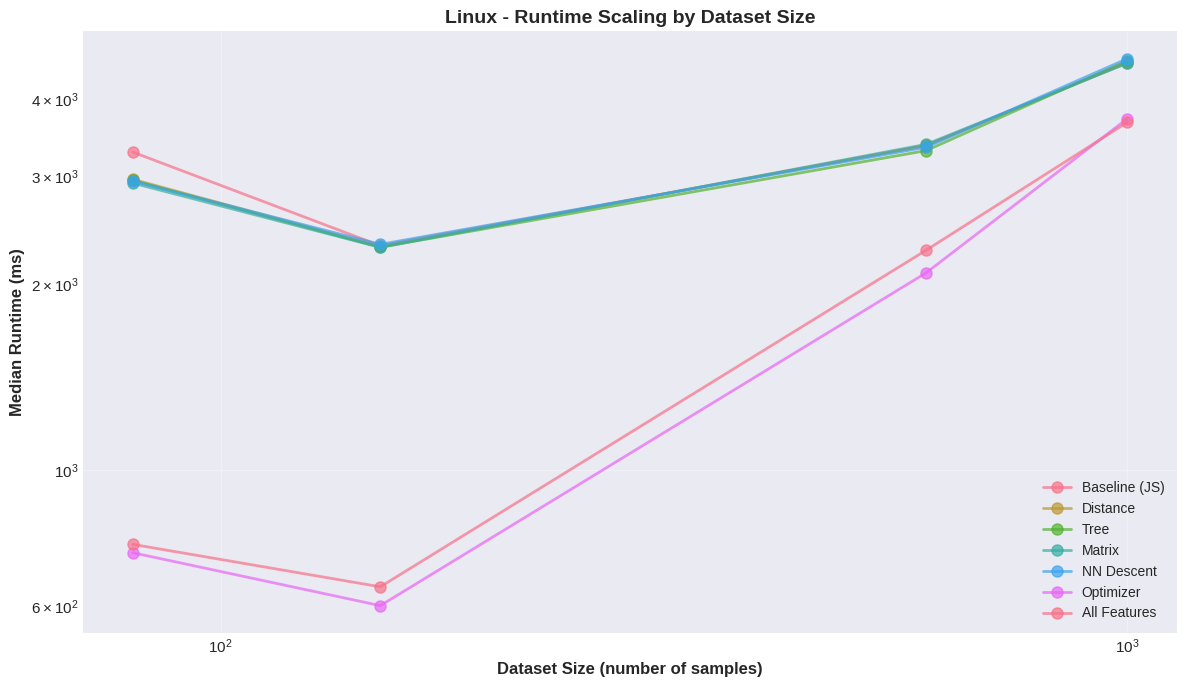

Note: Log-log scale used to show scaling behavior across different dataset sizes.


In [13]:
# Visualize runtime scaling with dataset size
fig, ax = plt.subplots(figsize=(12, 7))

feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

for feature in feature_order:
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    if len(feature_data) == 0:
        continue
    
    # Group by dataset size and calculate median runtime
    size_runtime = feature_data.groupby('dataset_size')['runtime_ms'].median().sort_index()
    
    ax.plot(size_runtime.index, size_runtime.values, 
           marker='o', label=feature, linewidth=2, markersize=8, alpha=0.7)

ax.set_xlabel('Dataset Size (number of samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Median Runtime (ms)', fontsize=12, fontweight='bold')
ax.set_title(f'{SELECTED_MACHINE} - Runtime Scaling by Dataset Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_scaling_by_size.png', bbox_inches='tight')
plt.show()

print("Note: Log-log scale used to show scaling behavior across different dataset sizes.")

In [14]:
# Analyze speedup by dataset size
def calculate_speedup_by_size(df, baseline_feature='Baseline (JS)'):
    """
    Calculate speedup relative to baseline for each dataset size.
    """
    results = []
    
    for (size, machine), group in df.groupby(['dataset_size', 'machine_type']):
        baseline = group[group['feature_name'] == baseline_feature]['runtime_ms']
        
        if len(baseline) == 0:
            continue
            
        baseline_median = baseline.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline_feature:
                continue
                
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset_size': size,
                'machine': machine,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

speedup_by_size_df = calculate_speedup_by_size(df_analysis)

print(f"Speedup by Dataset Size - {SELECTED_MACHINE}:")
print("\nAverage speedup across size categories:")
speedup_summary_by_size = speedup_by_size_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std'],
    'improvement_pct': ['mean', 'median']
}).round(3)
speedup_summary_by_size

Speedup by Dataset Size - Linux:

Average speedup across size categories:


speedup               improvement_pct         
                mean median    std            mean   median
feature                                                    
All Features   2.660  2.528  1.528         165.971  152.752
Distance       1.028  1.003  0.053           2.825    0.321
Matrix         1.032  1.006  0.060           3.228    0.561
NN Descent     1.026  1.000  0.060           2.588    0.047
Optimizer      2.788  2.723  1.605         178.763  172.303
Tree           1.033  1.012  0.053           3.286    1.225

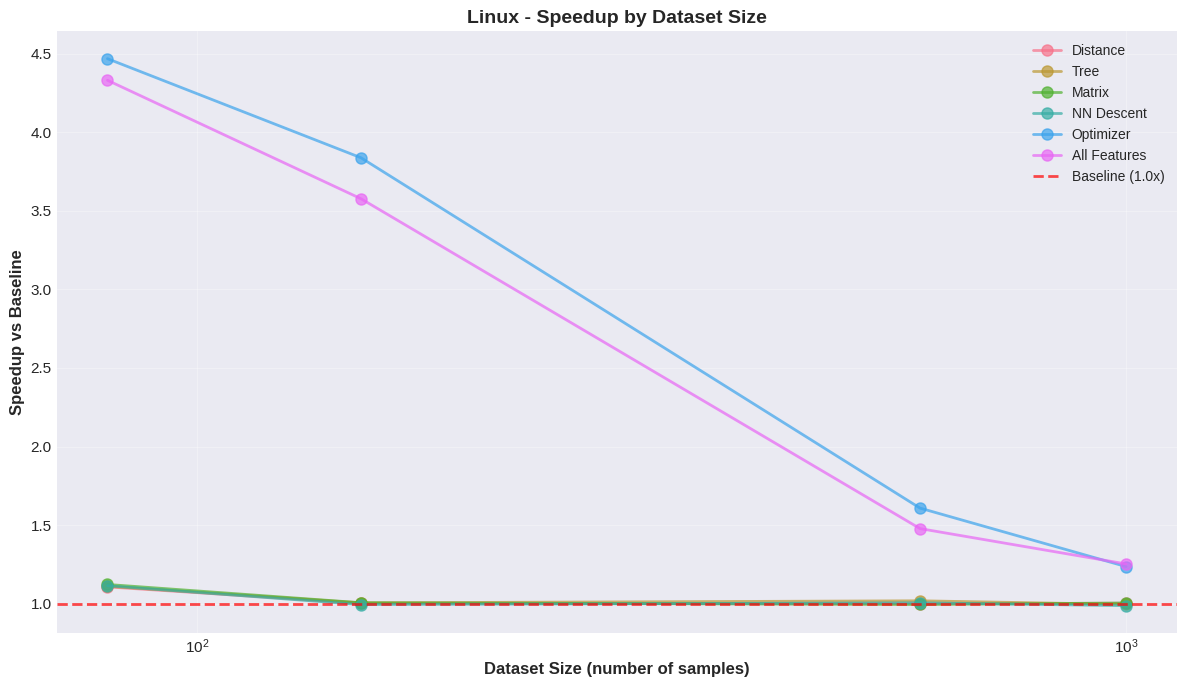

Note: Shows whether WASM benefits increase or decrease with dataset size.


In [15]:
# Visualize speedup trends by dataset size
fig, ax = plt.subplots(figsize=(12, 7))

feature_order = ['Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in speedup_by_size_df['feature'].unique()]

for feature in feature_order:
    feature_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature]
    if len(feature_data) == 0:
        continue
    
    # Sort by dataset size
    feature_data = feature_data.sort_values('dataset_size')
    
    ax.plot(feature_data['dataset_size'], feature_data['speedup'], 
           marker='o', label=feature, linewidth=2, markersize=8, alpha=0.7)

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Baseline (1.0x)')
ax.set_xlabel('Dataset Size (number of samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup vs Baseline', fontsize=12, fontweight='bold')
ax.set_title(f'{SELECTED_MACHINE} - Speedup by Dataset Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_by_dataset_size.png', bbox_inches='tight')
plt.show()

print("Note: Shows whether WASM benefits increase or decrease with dataset size.")

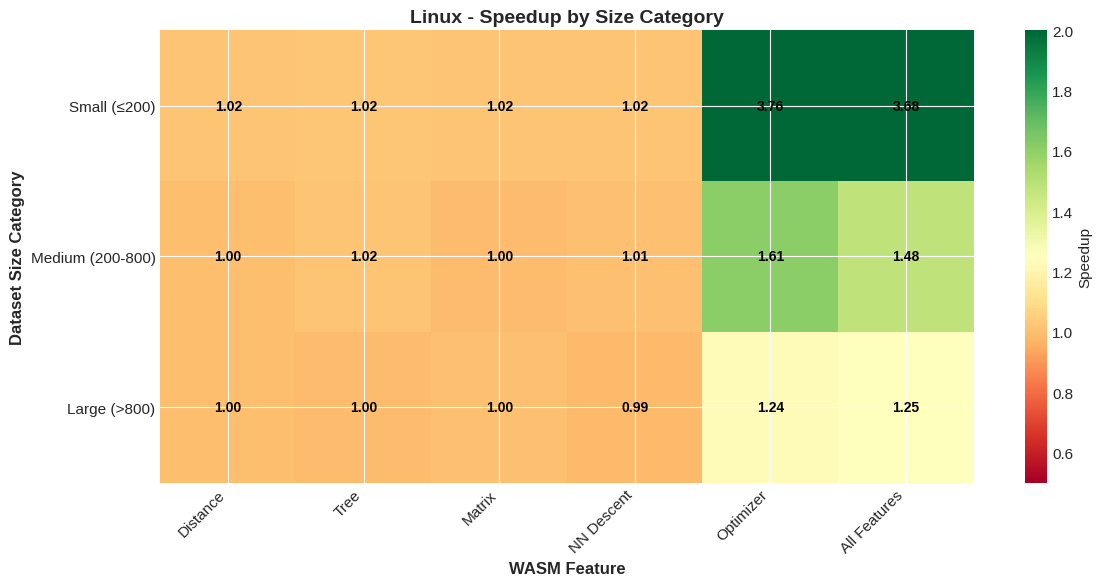

Note: Green = faster than baseline, Red = slower than baseline


In [17]:
# Heatmap of speedup by size category and feature
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate speedup for each size category and feature
speedup_matrix = []
size_cats = df_analysis['size_category'].dropna().unique()
size_cats = sorted(size_cats, key=lambda x: ['Small (≤200)', 'Medium (200-800)', 'Large (>800)'].index(x) if x in ['Small (≤200)', 'Medium (200-800)', 'Large (>800)'] else 999)

for size_cat in size_cats:
    size_data = df_analysis[df_analysis['size_category'] == size_cat]
    baseline = size_data[size_data['feature_name'] == 'Baseline (JS)']['runtime_ms'].median()
    
    if pd.isna(baseline) or baseline == 0:
        continue
    
    row = []
    for feature in feature_order:
        feature_data = size_data[size_data['feature_name'] == feature]
        if len(feature_data) > 0:
            speedup = baseline / feature_data['runtime_ms'].median()
            row.append(speedup)
        else:
            row.append(np.nan)
    
    if row:
        speedup_matrix.append(row)

if speedup_matrix:
    speedup_matrix = np.array(speedup_matrix)
    
    im = ax.imshow(speedup_matrix, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=2.0)
    ax.set_xticks(np.arange(len(feature_order)))
    ax.set_yticks(np.arange(len(size_cats[:len(speedup_matrix)])))
    ax.set_xticklabels(feature_order, rotation=45, ha='right')
    ax.set_yticklabels(size_cats[:len(speedup_matrix)])
    ax.set_title(f'{SELECTED_MACHINE} - Speedup by Size Category', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Dataset Size Category', fontsize=12, fontweight='bold')
    
    # Add text annotations
    for i in range(len(speedup_matrix)):
        for j in range(len(feature_order)):
            if not np.isnan(speedup_matrix[i, j]):
                text = ax.text(j, i, f'{speedup_matrix[i, j]:.2f}',
                            ha="center", va="center", color="black", fontsize=10, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Speedup', fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_heatmap_by_size.png', bbox_inches='tight')
plt.show()

print("Note: Green = faster than baseline, Red = slower than baseline")

In [18]:
# Summary statistics: Speedup by size category
print("=" * 80)
print(f"DATASET SIZE ANALYSIS SUMMARY - {SELECTED_MACHINE}")
print("=" * 80)

# Group by feature and calculate statistics
size_analysis = speedup_by_size_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'min', 'max', 'std']
}).round(3)

print(size_analysis)

# Find which features scale better with size
print(f"\nScaling behavior:")
for feature in speedup_by_size_df['feature'].unique():
    feat_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature].sort_values('dataset_size')
    if len(feat_data) > 1:
        # Simple trend: compare smallest vs largest
        small_speedup = feat_data.iloc[0]['speedup']
        large_speedup = feat_data.iloc[-1]['speedup']
        trend = "improves" if large_speedup > small_speedup else "degrades"
        print(f"  {feature}: {trend} with size ({small_speedup:.2f}x → {large_speedup:.2f}x)")

print("\n" + "=" * 80)

DATASET SIZE ANALYSIS SUMMARY - Linux
             speedup                            
                mean median    min    max    std
feature                                         
All Features   2.660  2.528  1.253  4.331  1.528
Distance       1.028  1.003  0.999  1.107  0.053
Matrix         1.032  1.006  0.995  1.123  0.060
NN Descent     1.026  1.000  0.988  1.115  0.060
Optimizer      2.788  2.723  1.236  4.468  1.605
Tree           1.033  1.012  0.996  1.111  0.053

Scaling behavior:
  All Features: degrades with size (4.33x → 1.25x)
  Distance: degrades with size (1.11x → 1.00x)
  Tree: degrades with size (1.11x → 1.00x)
  Matrix: degrades with size (1.12x → 1.00x)
  NN Descent: degrades with size (1.11x → 0.99x)
  Optimizer: degrades with size (4.47x → 1.24x)



## 5. Statistical Testing

Perform rigorous statistical tests to determine if differences are significant.

In [19]:
def mann_whitney_test(df, baseline_feature='Baseline (JS)'):
    """
    Perform Mann-Whitney U test comparing each feature to baseline.
    """
    results = []
    
    baseline = df[df['feature_name'] == baseline_feature]['runtime_ms'].dropna()
    
    if len(baseline) < 3:
        print("Insufficient baseline data for testing")
        return pd.DataFrame()
    
    for feature in df['feature_name'].unique():
        if feature == baseline_feature:
            continue
        
        feature_data = df[df['feature_name'] == feature]['runtime_ms'].dropna()
        
        if len(feature_data) < 3:
            continue
        
        # Mann-Whitney U test
        statistic, p_value = mannwhitneyu(baseline, feature_data, alternative='two-sided')
        
        # Effect size (Cohen's d approximation)
        mean_diff = feature_data.mean() - baseline.mean()
        pooled_std = np.sqrt((baseline.std()**2 + feature_data.std()**2) / 2)
        cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
        
        # Cliff's Delta (effect size for non-parametric test)
        n1, n2 = len(baseline), len(feature_data)
        pairs_greater = sum(1 for b in baseline for f in feature_data if b > f)
        pairs_less = sum(1 for b in baseline for f in feature_data if b < f)
        cliffs_delta = (pairs_greater - pairs_less) / (n1 * n2)
        
        results.append({
            'feature': feature,
            'n_baseline': len(baseline),
            'n_feature': len(feature_data),
            'baseline_median': baseline.median(),
            'feature_median': feature_data.median(),
            'p_value': p_value,
            'significant': p_value < 0.05,
            'cohens_d': cohens_d,
            'cliffs_delta': cliffs_delta
        })
    
    return pd.DataFrame(results)

# Perform tests
test_results = mann_whitney_test(df_analysis)

print(f"Statistical Test Results (Mann-Whitney U Test) - {SELECTED_MACHINE}:")
print("\nSignificance: p < 0.05")
print("Cliff's Delta interpretation: |δ| < 0.147 (negligible), < 0.33 (small), < 0.474 (medium), >= 0.474 (large)\n")
test_results.round(4)

Statistical Test Results (Mann-Whitney U Test) - Linux:

Significance: p < 0.05
Cliff's Delta interpretation: |δ| < 0.147 (negligible), < 0.33 (small), < 0.474 (medium), >= 0.474 (large)



,feature,n_baseline,n_feature,baseline_median,feature_median,p_value,significant,cohens_d,cliffs_delta
0,All Features,60,60,3559.85,2272.45,0.000,True,-1.329,0.571
1,Distance,60,60,3559.85,3360.75,0.633,False,-0.056,0.051
2,Tree,60,60,3559.85,3340.90,0.470,False,-0.065,0.077
3,Matrix,60,60,3559.85,3492.45,0.470,False,0.013,0.077
4,NN Descent,60,60,3559.85,3498.30,0.985,False,-0.021,0.002
5,Optimizer,60,60,3559.85,2088.40,0.000,True,-1.331,0.563


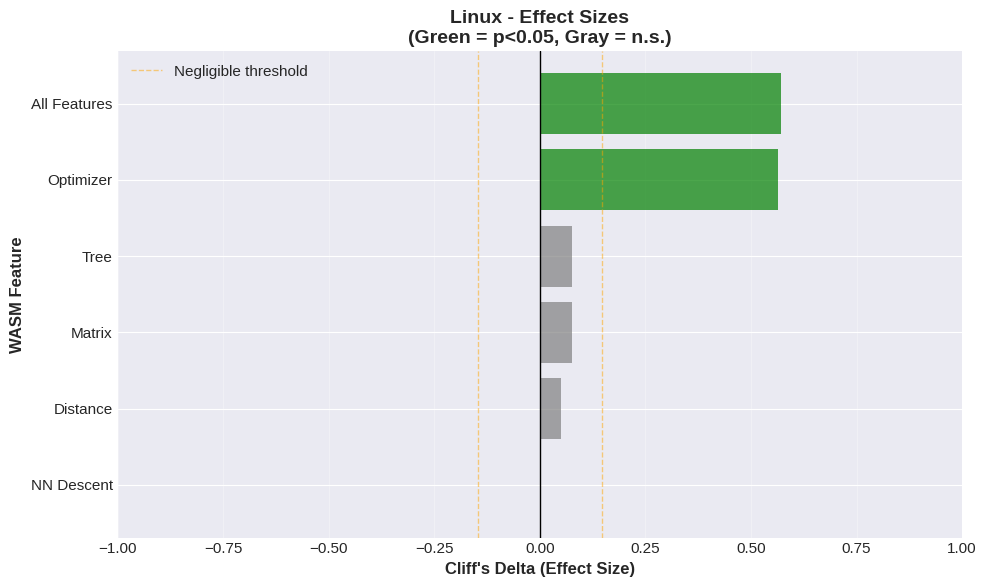

Note: Negative Cliff's Delta = feature is faster than baseline
      Positive Cliff's Delta = feature is slower than baseline


In [20]:
# Visualize statistical significance
fig, ax = plt.subplots(figsize=(10, 6))

if len(test_results) > 0:
    # Sort by Cliff's delta
    test_results_sorted = test_results.sort_values('cliffs_delta')
    
    colors = ['green' if sig else 'gray' for sig in test_results_sorted['significant']]
    
    ax.barh(test_results_sorted['feature'], test_results_sorted['cliffs_delta'], color=colors, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.axvline(x=-0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Negligible threshold')
    ax.axvline(x=0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel("Cliff's Delta (Effect Size)", fontsize=12, fontweight='bold')
    ax.set_ylabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_title(f'{SELECTED_MACHINE} - Effect Sizes\n(Green = p<0.05, Gray = n.s.)', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(-1, 1)
    ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/effect_sizes.png', bbox_inches='tight')
plt.show()

print("Note: Negative Cliff's Delta = feature is faster than baseline")
print("      Positive Cliff's Delta = feature is slower than baseline")

## 6. Bootstrap Confidence Intervals

Calculate robust confidence intervals for median speedups using bootstrap resampling.

In [21]:
def bootstrap_speedup_ci(df, baseline_feature='Baseline (JS)', n_bootstrap=10000, confidence=0.95):
    """
    Calculate bootstrap confidence intervals for speedup.
    """
    results = []
    rng = np.random.default_rng(42)
    
    baseline = df[df['feature_name'] == baseline_feature]['runtime_ms'].dropna().values
    
    if len(baseline) < 3:
        print("Insufficient baseline data for bootstrap")
        return pd.DataFrame()
    
    for feature in df['feature_name'].unique():
        if feature == baseline_feature:
            continue
        
        feature_data = df[df['feature_name'] == feature]['runtime_ms'].dropna().values
        
        if len(feature_data) < 3:
            continue
        
        # Bootstrap speedup
        speedups = []
        for _ in range(n_bootstrap):
            base_sample = rng.choice(baseline, size=len(baseline), replace=True)
            feat_sample = rng.choice(feature_data, size=len(feature_data), replace=True)
            speedup = np.median(base_sample) / np.median(feat_sample)
            speedups.append(speedup)
        
        speedups = np.array(speedups)
        alpha = 1 - confidence
        ci_lower = np.percentile(speedups, alpha/2 * 100)
        ci_upper = np.percentile(speedups, (1 - alpha/2) * 100)
        
        results.append({
            'feature': feature,
            'speedup_median': np.median(speedups),
            'speedup_mean': np.mean(speedups),
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower
        })
    
    return pd.DataFrame(results)

# Calculate bootstrap CIs
print(f"Calculating bootstrap confidence intervals (10,000 iterations) for {SELECTED_MACHINE}...")
bootstrap_results = bootstrap_speedup_ci(df_analysis)

print("\nBootstrap 95% Confidence Intervals for Speedup:\n")
bootstrap_results.round(3)

Calculating bootstrap confidence intervals (10,000 iterations) for Linux...

Bootstrap 95% Confidence Intervals for Speedup:



,feature,speedup_median,speedup_mean,ci_lower,ci_upper,ci_width
0,All Features,1.591,1.717,1.320,2.230,0.910
1,Distance,1.032,1.056,0.871,1.230,0.360
2,Tree,1.035,1.069,0.870,1.264,0.394
3,Matrix,1.017,1.051,0.869,1.258,0.389
4,NN Descent,1.019,1.040,0.866,1.238,0.372
5,Optimizer,1.754,1.772,1.328,2.203,0.876


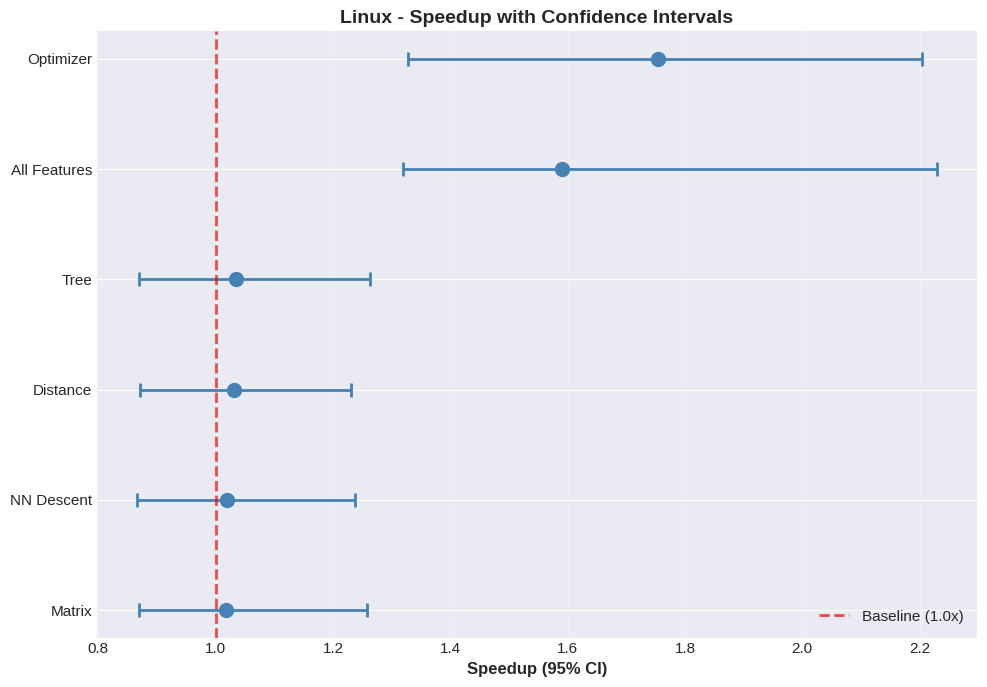

In [22]:
# Visualize confidence intervals
fig, ax = plt.subplots(figsize=(10, 7))

if len(bootstrap_results) > 0:
    bootstrap_results_sorted = bootstrap_results.sort_values('speedup_median')
    
    y_pos = np.arange(len(bootstrap_results_sorted))
    
    # Plot error bars
    ax.errorbar(
        bootstrap_results_sorted['speedup_median'],
        y_pos,
        xerr=[
            bootstrap_results_sorted['speedup_median'] - bootstrap_results_sorted['ci_lower'],
            bootstrap_results_sorted['ci_upper'] - bootstrap_results_sorted['speedup_median']
        ],
        fmt='o',
        markersize=10,
        capsize=5,
        capthick=2,
        elinewidth=2,
        color='steelblue'
    )
    
    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(bootstrap_results_sorted['feature'])
    ax.set_xlabel('Speedup (95% CI)', fontsize=12, fontweight='bold')
    ax.set_title(f'{SELECTED_MACHINE} - Speedup with Confidence Intervals', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_confidence_intervals.png', bbox_inches='tight')
plt.show()

## 7. Quality and Responsiveness Analysis

Analyze the trade-offs between performance and output quality/responsiveness.

In [23]:
# Quality comparison
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

quality_summary = df_analysis.groupby('feature_name').agg({
    'trustworthiness': ['mean', 'median', 'std', 'count'],
    'fps_avg': ['mean', 'median'],
    'responsiveness_ms': ['mean', 'median']
}).round(4)

print(f"Quality and Responsiveness by Feature - {SELECTED_MACHINE}:\n")
quality_summary

Quality and Responsiveness by Feature - Linux:



trustworthiness                     fps_avg         responsiveness_ms        
                         mean median    std count    mean  median              mean  median
feature_name                                                                               
All Features            0.889  0.967  0.154    60  28.521  37.572            33.944  20.703
Baseline (JS)           0.900  0.970  0.140    60  54.909  56.440            36.892  22.493
Distance                0.901  0.969  0.139    60  55.194  56.987            36.697  21.532
Matrix                  0.902  0.970  0.140    60  54.915  56.919            34.293  20.790
NN Descent              0.900  0.970  0.140    60  54.991  57.023            36.133  21.820
Optimizer               0.888  0.967  0.156    60  27.910  37.837            35.930  22.053
Tree                    0.899  0.969  0.140    60  55.169  56.934            35.776  22.040

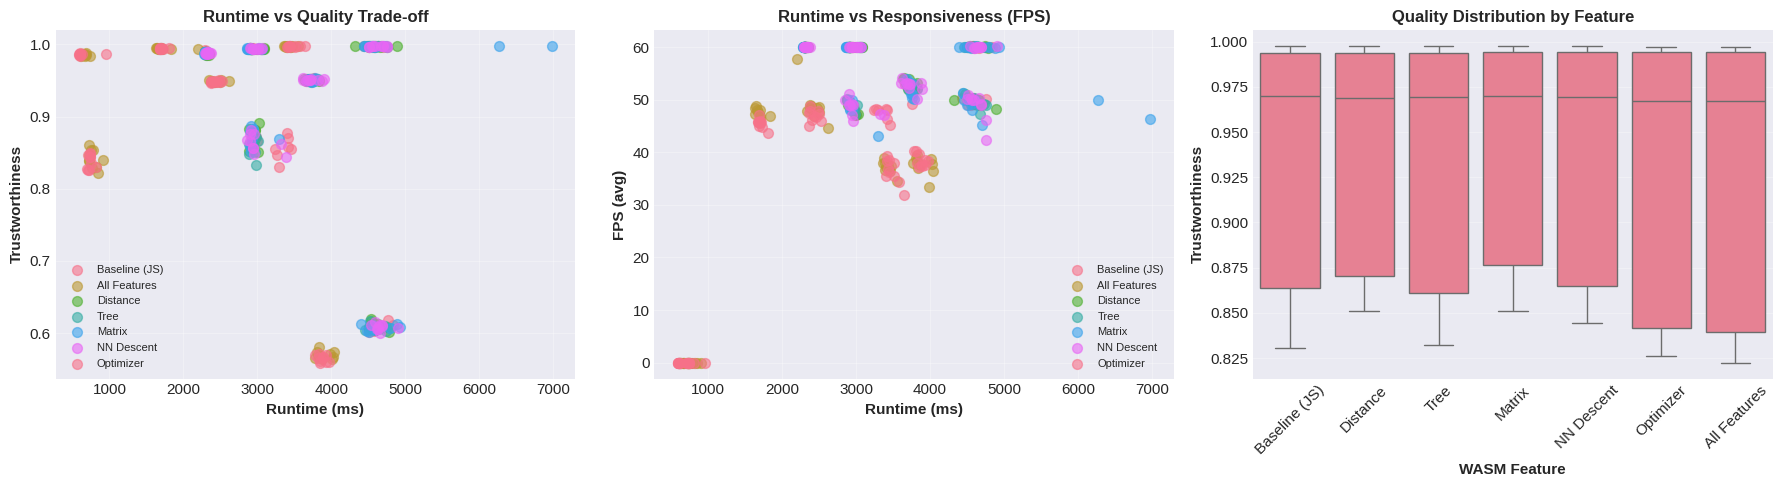

In [24]:
# Visualize quality vs performance trade-off
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Runtime vs Quality
for feature in df_analysis['feature_name'].unique():
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    axes[0].scatter(feature_data['runtime_ms'], feature_data['trustworthiness'], 
                   label=feature, alpha=0.6, s=50)

axes[0].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[0].set_title('Runtime vs Quality Trade-off', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=8, loc='best')
axes[0].grid(alpha=0.3)

# Runtime vs FPS
for feature in df_analysis['feature_name'].unique():
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    axes[1].scatter(feature_data['runtime_ms'], feature_data['fps_avg'], 
                   label=feature, alpha=0.6, s=50)

axes[1].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
axes[1].set_title('Runtime vs Responsiveness (FPS)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8, loc='best')
axes[1].grid(alpha=0.3)

# Quality by feature (boxplot)
sns.boxplot(data=df_analysis, x='feature_name', y='trustworthiness', 
            order=feature_order, ax=axes[2], showfliers=False)
axes[2].set_xlabel('WASM Feature', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[2].set_title('Quality Distribution by Feature', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/quality_tradeoffs.png', bbox_inches='tight')
plt.show()

## 8. Feature Ranking and Recommendations

Rank features based on multiple criteria for practical recommendations.

In [25]:
# Calculate composite scores
def calculate_composite_scores(df, baseline='Baseline (JS)'):
    """
    Calculate composite performance scores for each feature.
    """
    results = []
    
    for feature in df['feature_name'].unique():
        if feature == baseline:
            continue
        
        feature_data = df[df['feature_name'] == feature]
        baseline_data = df[df['feature_name'] == baseline]
        
        # Calculate metrics relative to baseline
        speedup = baseline_data['runtime_ms'].median() / feature_data['runtime_ms'].median()
        quality_ratio = feature_data['trustworthiness'].median() / baseline_data['trustworthiness'].median()
        fps_ratio = feature_data['fps_avg'].median() / baseline_data['fps_avg'].median()
        
        # Memory impact (negative is better)
        memory_delta = feature_data['memory_delta_mb'].median()
        
        # Composite score (higher is better)
        # Weights: 50% speedup, 25% quality, 15% FPS, 10% memory
        composite = (0.50 * speedup + 
                    0.25 * quality_ratio + 
                    0.15 * fps_ratio - 
                    0.10 * abs(memory_delta / 10))  # Normalize memory
        
        results.append({
            'feature': feature,
            'speedup': speedup,
            'quality_ratio': quality_ratio,
            'fps_ratio': fps_ratio,
            'memory_delta_mb': memory_delta,
            'composite_score': composite
        })
    
    return pd.DataFrame(results).sort_values('composite_score', ascending=False)

# Calculate rankings
print(f"Feature Rankings by Composite Score - {SELECTED_MACHINE}:\n")
print('='*70)
rankings = calculate_composite_scores(df_analysis)
print(rankings.round(3).to_string(index=False))

Feature Rankings by Composite Score - Linux:

     feature  speedup  quality_ratio  fps_ratio  memory_delta_mb  composite_score
   Optimizer    1.705          0.997      0.670            2.022            1.182
All Features    1.567          0.997      0.666           12.181            1.011
      Matrix    1.019          1.000      1.008           10.819            0.803
    Distance    1.059          0.999      1.010           14.021            0.791
        Tree    1.066          0.999      1.009           14.820            0.786
  NN Descent    1.018          0.999      1.010           14.170            0.768


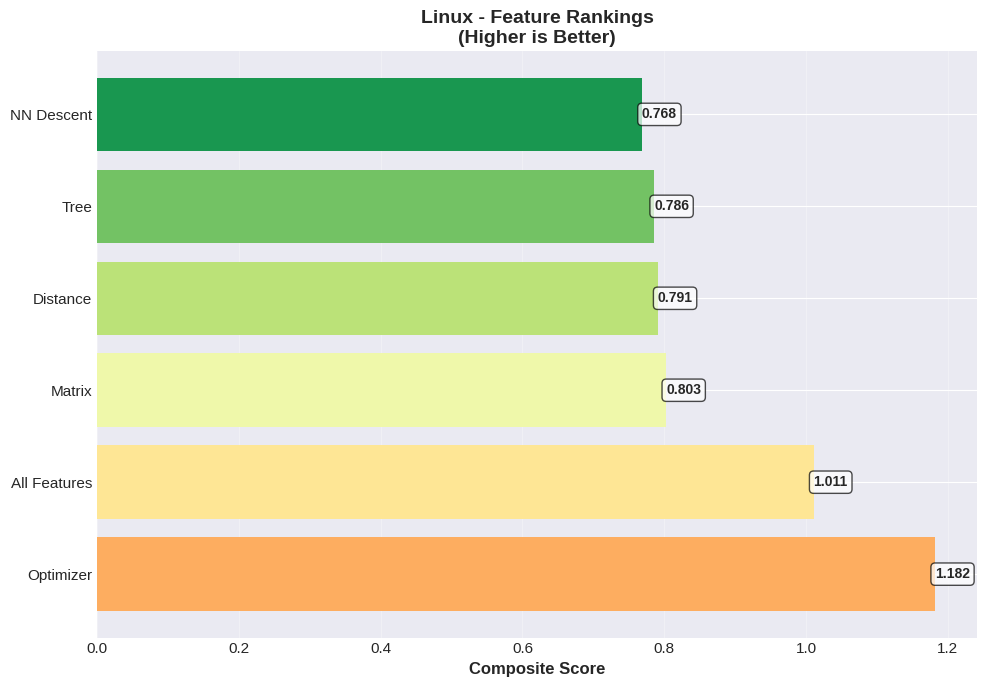

In [26]:
# Visualize feature rankings
fig, ax = plt.subplots(figsize=(10, 7))

rankings = calculate_composite_scores(df_analysis)

if len(rankings) > 0:
    # Create color gradient
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(rankings)))
    
    bars = ax.barh(rankings['feature'], rankings['composite_score'], color=colors)
    ax.set_xlabel('Composite Score', fontsize=12, fontweight='bold')
    ax.set_title(f'{SELECTED_MACHINE} - Feature Rankings\n(Higher is Better)', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
               f'{width:.3f}',
               ha='left', va='center', fontsize=10, fontweight='bold', 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('../outputs/figures/feature_rankings.png', bbox_inches='tight')
plt.show()

## 9. Summary Statistics and Export

Generate comprehensive summary tables for thesis inclusion.

In [27]:
# Create output directory
os.makedirs('../outputs/summaries', exist_ok=True)

# Export all summary tables
speedup_df.to_csv(f'../outputs/summaries/speedup_summary_{SELECTED_MACHINE.lower()}.csv', index=False)
test_results.to_csv(f'../outputs/summaries/statistical_tests_{SELECTED_MACHINE.lower()}.csv', index=False)
bootstrap_results.to_csv(f'../outputs/summaries/bootstrap_confidence_intervals_{SELECTED_MACHINE.lower()}.csv', index=False)
quality_summary.to_csv(f'../outputs/summaries/quality_summary_{SELECTED_MACHINE.lower()}.csv')

# Export rankings
rankings = calculate_composite_scores(df_analysis)
rankings.to_csv(f'../outputs/summaries/rankings_{SELECTED_MACHINE.lower()}.csv', index=False)

print(f"All results for {SELECTED_MACHINE} exported to ../outputs/ directory")

All results for Linux exported to ../outputs/ directory


In [28]:
# Generate thesis-ready summary

summary_md = f"""
# UMAP WebAssembly Performance Analysis - Summary

## Analysis Configuration
- **Machine**: {SELECTED_MACHINE}
- **Total Measurements**: {len(df_analysis):,}
- **Datasets Tested**: {df_analysis['dataset_name'].nunique()}
- **Features Tested**: {df_analysis['feature_name'].nunique()}

## Key Findings

### RQ1: Individual WASM Feature Performance

**Speedup ranges (median across all tests):**
"""

for feature in speedup_df['feature'].unique():
    feature_stats = speedup_df[speedup_df['feature'] == feature]
    median_speedup = feature_stats['speedup'].median()
    min_speedup = feature_stats['speedup'].min()
    max_speedup = feature_stats['speedup'].max()
    
    # Determine if improvement or regression
    if median_speedup > 1.05:
        verdict = "✓ Performance improvement"
    elif median_speedup < 0.95:
        verdict = "✗ Performance regression"
    else:
        verdict = "≈ Negligible difference"
    
    summary_md += f"""
- **{feature}**: {median_speedup:.2f}x (range: {min_speedup:.2f}x - {max_speedup:.2f}x) - {verdict}
"""

summary_md += f"""

### RQ2: All Features Combined vs Individual Features

"""

if 'All Features' in speedup_df['feature'].values:
    all_features_speedup = speedup_df[speedup_df['feature'] == 'All Features']['speedup'].median()
    best_speedup = speedup_df.groupby('feature')['speedup'].median().max()
    best_feature = speedup_df.groupby('feature')['speedup'].median().idxmax()
    summary_md += f"""
- **All Features Combined**: {all_features_speedup:.2f}x median speedup
- **Best Individual Feature**: {best_feature} ({best_speedup:.2f}x)
- **Comparison**: {'All Features is best' if all_features_speedup >= best_speedup else f'{best_feature} outperforms All Features'}
"""
else:
    summary_md += """
- No data available for "All Features" configuration
"""

summary_md += f"""

### Statistical Significance

- **Total comparisons**: {len(test_results)}
- **Significant results (p < 0.05)**: {test_results['significant'].sum()} ({test_results['significant'].sum()/len(test_results)*100:.1f}%)
- **Large effect sizes (|Cliff's δ| > 0.474)**: {(abs(test_results['cliffs_delta']) > 0.474).sum()}
- **Medium effect sizes (0.33 < |Cliff's δ| < 0.474)**: {((abs(test_results['cliffs_delta']) > 0.33) & (abs(test_results['cliffs_delta']) <= 0.474)).sum()}

### Quality Trade-offs

- **Mean Trustworthiness**: {df_analysis['trustworthiness'].mean():.4f} (±{df_analysis['trustworthiness'].std():.4f})
- **Quality Range**: {df_analysis['trustworthiness'].min():.4f} - {df_analysis['trustworthiness'].max():.4f}
- **Quality Stability**: All features maintain trustworthiness > {df_analysis.groupby('feature_name')['trustworthiness'].median().min():.3f}

### Performance Rankings

**Top 3 Features by Composite Score:**
"""

rankings = calculate_composite_scores(df_analysis)
for idx, row in rankings.head(3).iterrows():
    summary_md += f"""
{idx+1}. **{row['feature']}** (score: {row['composite_score']:.3f})
   - Speedup: {row['speedup']:.2f}x
   - Quality ratio: {row['quality_ratio']:.3f}
   - FPS ratio: {row['fps_ratio']:.3f}
"""

summary_md += f"""

## Dataset Size Effects

**Scaling behavior across dataset sizes ({df_analysis['dataset_size'].min():.0f} - {df_analysis['dataset_size'].max():.0f} samples):**

"""

for feature in speedup_by_size_df['feature'].unique():
    feat_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature].sort_values('dataset_size')
    if len(feat_data) > 1:
        small_speedup = feat_data.iloc[0]['speedup']
        large_speedup = feat_data.iloc[-1]['speedup']
        trend = "improves" if large_speedup > small_speedup else "degrades"
        change_pct = ((large_speedup - small_speedup) / small_speedup * 100)
        summary_md += f"- **{feature}**: {trend} ({small_speedup:.2f}x → {large_speedup:.2f}x, {change_pct:+.1f}%)\n"

summary_md += f"""

## Recommendations

1. **Best Overall Performance**: {rankings.iloc[0]['feature']} (composite score: {rankings.iloc[0]['composite_score']:.3f})
2. **Fastest Execution**: {speedup_df.groupby('feature')['speedup'].median().idxmax()} ({speedup_df.groupby('feature')['speedup'].median().max():.2f}x speedup)
3. **Most Consistent**: Feature with lowest variance across datasets
4. **Quality Preservation**: All WASM features maintain high trustworthiness (> {df_analysis.groupby('feature_name')['trustworthiness'].median().min():.3f})

## Analysis Methodology

- **Statistical Method**: Mann-Whitney U tests (non-parametric)
- **Confidence Intervals**: Bootstrap resampling (10,000 iterations)
- **Effect Size Metric**: Cliff's Delta
- **Significance Level**: α = 0.05

---
*Analysis performed on {SELECTED_MACHINE} with {len(df_analysis):,} measurements across {df_analysis['dataset_name'].nunique()} datasets*
"""

display(Markdown(summary_md))

# Save summary
with open(f'../outputs/summaries/thesis_summary_{SELECTED_MACHINE.lower()}.md', 'w') as f:
    f.write(summary_md)

print("\n" + "="*80)
print(f"Summary saved to: analysis_outputs/thesis_summary_{SELECTED_MACHINE.lower()}.md")
print("="*80)


# UMAP WebAssembly Performance Analysis - Summary

## Analysis Configuration
- **Machine**: Linux
- **Total Measurements**: 420
- **Datasets Tested**: 6
- **Features Tested**: 7

## Key Findings

### RQ1: Individual WASM Feature Performance

**Speedup ranges (median across all tests):**

- **All Features**: 1.64x (range: 1.19x - 4.33x) - ✓ Performance improvement

- **Distance**: 1.00x (range: 0.97x - 1.11x) - ≈ Negligible difference

- **Tree**: 1.00x (range: 0.99x - 1.11x) - ≈ Negligible difference

- **Matrix**: 1.01x (range: 1.00x - 1.12x) - ≈ Negligible difference

- **NN Descent**: 0.99x (range: 0.99x - 1.11x) - ≈ Negligible difference

- **Optimizer**: 1.63x (range: 1.19x - 4.47x) - ✓ Performance improvement


### RQ2: All Features Combined vs Individual Features


- **All Features Combined**: 1.64x median speedup
- **Best Individual Feature**: All Features (1.64x)
- **Comparison**: All Features is best


### Statistical Significance

- **Total comparisons**: 6
- **Significant results (p < 0.05)**: 2 (33.3%)
- **Large effect sizes (|Cliff's δ| > 0.474)**: 2
- **Medium effect sizes (0.33 < |Cliff's δ| < 0.474)**: 0

### Quality Trade-offs

- **Mean Trustworthiness**: 0.8971 (±0.1433)
- **Quality Range**: 0.5589 - 0.9975
- **Quality Stability**: All features maintain trustworthiness > 0.967

### Performance Rankings

**Top 3 Features by Composite Score:**

6. **Optimizer** (score: 1.182)
   - Speedup: 1.70x
   - Quality ratio: 0.997
   - FPS ratio: 0.670

1. **All Features** (score: 1.011)
   - Speedup: 1.57x
   - Quality ratio: 0.997
   - FPS ratio: 0.666

4. **Matrix** (score: 0.803)
   - Speedup: 1.02x
   - Quality ratio: 1.000
   - FPS ratio: 1.008


## Dataset Size Effects

**Scaling behavior across dataset sizes (80 - 1000 samples):**

- **All Features**: degrades (4.33x → 1.25x, -71.1%)
- **Distance**: degrades (1.11x → 1.00x, -9.4%)
- **Tree**: degrades (1.11x → 1.00x, -10.4%)
- **Matrix**: degrades (1.12x → 1.00x, -10.5%)
- **NN Descent**: degrades (1.11x → 0.99x, -11.4%)
- **Optimizer**: degrades (4.47x → 1.24x, -72.3%)


## Recommendations

1. **Best Overall Performance**: Optimizer (composite score: 1.182)
2. **Fastest Execution**: All Features (1.64x speedup)
3. **Most Consistent**: Feature with lowest variance across datasets
4. **Quality Preservation**: All WASM features maintain high trustworthiness (> 0.967)

## Analysis Methodology

- **Statistical Method**: Mann-Whitney U tests (non-parametric)
- **Confidence Intervals**: Bootstrap resampling (10,000 iterations)
- **Effect Size Metric**: Cliff's Delta
- **Significance Level**: α = 0.05

---
*Analysis performed on Linux with 420 measurements across 6 datasets*



Summary saved to: analysis_outputs/thesis_summary_linux.md
